In [1]:
import tensorflow as tf
import pickle
import gzip
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from util import *
sns.set()
sns.set_style('white')

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

%matplotlib inline

In [2]:
# Parameter Setting
n_samples = 10000
loc = np.array([0, 0])
sigma0 = np.array([[2, 1], [1, 2]])
sigma1 = np.array([[1, -2], [-2, 1]])

# Data Generation X
X_S_0 = np.random.multivariate_normal(loc, sigma0, int(n_samples/2))
X_S_1 = np.random.multivariate_normal(loc, sigma1, int(n_samples/2))
X = np.vstack((X_S_0, X_S_1))

# Data Generation Y
theta = 0.0*np.pi
normal_vec = np.array([-np.sin(theta), np.cos(theta)]).reshape((2, 1))
Y_S_0 = np.zeros((int(n_samples/2), 2))
Y_S_1 = np.zeros((int(n_samples/2), 2))

for i in range(len(Y_S_0)):
    if X_S_0[i, 1] >=0:
        Y_S_0[i, 0] = 1
    else:
        Y_S_0[i, 1] = 1
        
for i in range(len(Y_S_1)):
    if X_S_1[i, :].reshape((1, 2)).dot(normal_vec) >=0:
        Y_S_1[i, 0] = 1
    else:
        Y_S_1[i, 1] = 1
        
Y = np.vstack((Y_S_0, Y_S_1))

/Users/hsianghsu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  if __name__ == '__main__':


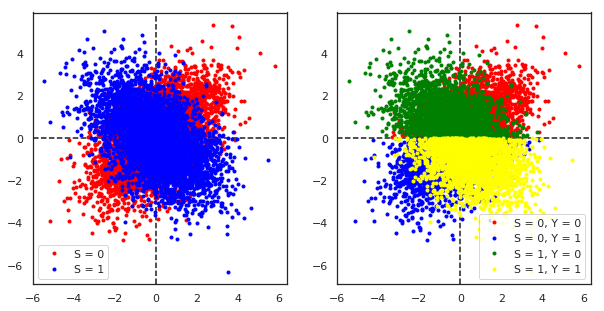

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Plot S
ax[0].axvline(x=0, color='k', linestyle='--')
ax[0].axhline(y=0, color='k', linestyle='--')

ax[0].plot(X_S_0[:, 0], X_S_0[:, 1], color='red', linestyle='', marker='.', label='S = 0')
ax[0].plot(X_S_1[:, 0], X_S_1[:, 1], color='blue', linestyle='', marker='.', label='S = 1')

ax[0].legend(loc='best')

# Plot Y
ax[1].axvline(x=0, color='k', linestyle='--')
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].plot(X_S_0[Y_S_0[:, 0]==1, 0], X_S_0[Y_S_0[:, 0]==1, 1], color='red', linestyle='', marker='.', label='S = 0, Y = 0')
ax[1].plot(X_S_0[Y_S_0[:, 1]==1, 0], X_S_0[Y_S_0[:, 1]==1, 1], color='blue', linestyle='', marker='.', label='S = 0, Y = 1')
ax[1].plot(X_S_1[Y_S_1[:, 0]==1, 0], X_S_1[Y_S_1[:, 0]==1, 1], color='green', linestyle='', marker='.', label='S = 1, Y = 0')
ax[1].plot(X_S_1[Y_S_1[:, 1]==1, 0], X_S_1[Y_S_1[:, 1]==1, 1], color='yellow', linestyle='', marker='.', label='S = 1, Y = 1')

ax[1].legend(loc='best')

### Experiments for different mis-alignment of the labeling functions (Run from Here)

In [2]:
def label_Y(X0, X1, theta):
    theta = 0.0*np.pi
    normal_vec = np.array([-np.sin(theta), np.cos(theta)]).reshape((2, 1))
    Y_S_0 = np.zeros((int(n_samples/2), 2))
    Y_S_1 = np.zeros((int(n_samples/2), 2))

    for i in range(len(Y_S_0)):
        if X_S_0[i, 1] >=0:
            Y_S_0[i, 0] = 1
        else:
            Y_S_0[i, 1] = 1

    for i in range(len(Y_S_1)):
        if X_S_1[i, :].reshape((1, 2)).dot(normal_vec) >=0:
            Y_S_1[i, 0] = 1
        else:
            Y_S_1[i, 1] = 1

    Y = np.vstack((Y_S_0, Y_S_1))
    return Y, Y_S_0, Y_S_1

In [3]:
# Parameter Setting
n_samples = 5000
loc = np.array([0, 0])
sigma0 = np.array([[2, 1], [1, 2]])
sigma1 = np.array([[1, -2], [-2, 1]])

# Data Generation X
X_S_0 = np.random.multivariate_normal(loc, sigma0, int(n_samples/2))
X_S_1 = np.random.multivariate_normal(loc, sigma1, int(n_samples/2))
X = np.vstack((X_S_0, X_S_1))

/Users/hsianghsu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  if __name__ == '__main__':


In [4]:
theta_arr = np.pi*np.linspace(0, 1, 10)
Y_dict = {}
for i in range(len(theta_arr)):
    theta = theta_arr[i]
    Y,_ ,_ = label_Y(X_S_0, X_S_1, theta)
    Y_dict[i] = Y

In [5]:
def train(idx, theta, X_data, Y_data, lr, n_epoch, n_input, n_output):
    # Split Data
    X0 = X_data[:int(X_data.shape[0]/2), :]
    X1 = X_data[int(X_data.shape[0]/2):, :]
    
    Y0 = Y_data[:int(Y_data.shape[0]/2), :]
    Y1 = Y_data[int(Y_data.shape[0]/2):, :]
    
    # Placeholders
    logit_out = tf.placeholder(tf.float32, [None, 2], name='Logits')
    Y = tf.placeholder(tf.float32, [None, 2], name='Y')
    lrate = tf.placeholder(tf.float32, name='learning_rate')
    
    # Construct Feed-forward Neural Networks
    x0_input, y0_out = SimpleNet(n_input, name="S0Net", structure = [30, 30, n_output])
    x1_input, y1_out = SimpleNet(n_input, name="S1Net", structure = [30, 30, n_output])
    x_input, y_out = SimpleNet(n_input, name="SNet", structure = [30, 30, n_output])
    
    # Pass the logit to softmax layer
    def predict(logits):
        return tf.nn.softmax(logits)
    
    # Define Losses
    loss0 = tf.nn.l2_loss(predict(y0_out)-Y0)
    loss1 = tf.nn.l2_loss(predict(y1_out)-Y1)
    loss = tf.nn.l2_loss(predict(y_out)-Y_data)
#     loss0 = tf.math.sqrt(tf.reduce_sum((predict(y0_out)-Y0)**2))
#     loss1 = tf.math.sqrt(tf.reduce_sum((predict(y1_out)-Y1)**2))
#     loss = tf.math.sqrt(tf.reduce_sum((predict(y_out)-Y_data)**2))
    
    correct_pred = tf.equal(tf.argmax(predict(logit_out), 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    l2 = tf.nn.l2_loss(tf.cast(tf.argmax(predict(logit_out), 1), tf.float32) - tf.cast(tf.argmax(Y, 1), tf.float32))
    
    # Define Optimizers
    optimizer0 = tf.train.GradientDescentOptimizer(lrate).minimize(loss0)
    optimizer1 = tf.train.GradientDescentOptimizer(lrate).minimize(loss1)
    optimizer = tf.train.GradientDescentOptimizer(lrate).minimize(loss)
    
    # Initialization
    session.run(tf.global_variables_initializer())
    
    # Training
    print('=== {} === Theta {:.2f} ==='.format(idx, theta))
    print('epoch\t loss0\t loss1\t loss')
    for epoch in range(n_epoch):
        _, curr_loss0, y0_logits = session.run([optimizer0, loss0, y0_out], feed_dict= {x0_input: X0, lrate: lr})
        _, curr_loss1, y1_logits = session.run([optimizer1, loss1, y1_out], feed_dict= {x1_input: X1, lrate: lr})
        _, curr_loss, y_logits = session.run([optimizer, loss, y_out], feed_dict= {x_input: X_data, lrate: lr})
        if epoch % 20 ==0:
            print('{}\t {:.2f}\t {:.2f}\t {:.2f}'.format(epoch, curr_loss0, curr_loss1, curr_loss))
    
    acc0 = accuracy.eval(feed_dict= {logit_out: y0_logits, Y: Y0}, session=session)
    acc1 = accuracy.eval(feed_dict= {logit_out: y1_logits, Y: Y1}, session=session)
    acc = accuracy.eval(feed_dict= {logit_out: y_logits, Y: Y_data}, session=session)
    
#     l20 = l2.eval(feed_dict= {logit_out: y0_logits, Y: Y0}, session=session)
#     l21 = l2.eval(feed_dict= {logit_out: y1_logits, Y: Y1}, session=session)
#     l2 = l2.eval(feed_dict= {logit_out: y_logits, Y: Y_data}, session=session)
    l20 = np.sqrt(np.mean((np.argmax(y0_logits, 1) - np.argmax(Y0, 1))**2))
    l21 = np.sqrt(np.mean((np.argmax(y1_logits, 1) - np.argmax(Y1, 1))**2))
    l2 = np.sqrt(np.mean((np.argmax(y_logits, 1) - np.argmax(Y_data, 1))**2))
    l2_diff = np.sqrt(np.mean((np.argmax(y0_logits, 1) - np.argmax(y1_logits, 1))**2))
    
    print('Acc0: {:.2f}, Acc1: {:.2f}, Acc: {:.2f}'.format(acc0, acc1, acc))
    
#     def compute_loss(logits, Y):
#         likelihood = predict(logits)
#         return tf.reduce_mean(tf.pow(tf.argmax(likelihood, 1) - tf.argmax(Y, 1), 2))
#         belief = np.array([likelihood[i, np.argmax(Y[i, :])] for i in range(Y.shape[0])])
        
#         return tf.sqrt(tf.reduce_sum(tf.pow((belief - np.argmax(Y, 1)), 2)))
    
#     eps_coupling = compute_loss(y_logits, Y_data) - np.max(np.array([compute_loss(y0_logits, Y0), compute_loss(y1_logits, Y1)]))
    
#     eps_coupling = curr_loss - np.max([curr_loss0, curr_loss1])
    eps_coupling = l2 - np.max([l20, l21])
    print('epsilon_coupling = {:.4f}'.format(eps_coupling))
    print(r'$\|h_1-h_0\|_2$ = {:.4f}'.format(l2_diff))
    return eps_coupling, l2_diff

In [6]:
learning_rate = 5e-4
Epoch = 100
dim_input = 2
dim_output = 2

eps_coupling_list = []
l2_list = []

session = tf.InteractiveSession()
for i in range(len(theta_arr)):
    eps, l2 = train(i, theta_arr[i], X, Y_dict[i], learning_rate, Epoch, dim_input, dim_output)
    eps_coupling_list.append(eps)
    l2_list.append(l2)
#     tf.reset_default_graph()
session.close()

=== 0 === Theta 0.00 ===
epoch	 loss0	 loss1	 loss
0	 642.98	 613.67	 1222.04
20	 71.42	 63.42	 72.42
40	 40.61	 35.22	 45.60
60	 30.33	 26.33	 35.51
80	 24.95	 21.79	 29.96
Acc0: 1.00, Acc1: 1.00, Acc: 1.00
epsilon_coupling = -0.0213
$\|h_1-h_0\|_2$ = 0.6971
=== 1 === Theta 0.35 ===
epoch	 loss0	 loss1	 loss
0	 644.13	 606.82	 1290.35
20	 73.02	 64.14	 76.19
40	 40.79	 35.33	 46.64
60	 30.33	 26.35	 35.99
80	 24.92	 21.77	 30.24
Acc0: 1.00, Acc1: 1.00, Acc: 1.00
epsilon_coupling = -0.0155
$\|h_1-h_0\|_2$ = 0.6971
=== 2 === Theta 0.70 ===
epoch	 loss0	 loss1	 loss
0	 631.01	 623.34	 1236.53
20	 67.35	 62.50	 72.93
40	 39.55	 34.98	 45.72
60	 29.81	 26.18	 35.56
80	 24.65	 21.67	 29.97
Acc0: 1.00, Acc1: 1.00, Acc: 1.00
epsilon_coupling = -0.0183
$\|h_1-h_0\|_2$ = 0.6971
=== 3 === Theta 1.05 ===
epoch	 loss0	 loss1	 loss
0	 609.07	 625.02	 1221.28
20	 67.37	 68.96	 72.49
40	 39.58	 36.39	 45.68
60	 29.84	 26.81	 35.58
80	 24.66	 22.04	 30.01
Acc0: 1.00, Acc1: 1.00, Acc: 1.00
epsilon_coup

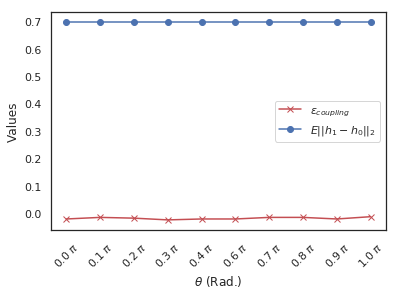

In [10]:
fig= plt.plot(figsize=(10, 5))
plt.plot(theta_arr, eps_coupling_list, 'rx-', label=r'$\epsilon_{coupling}$')
plt.plot(theta_arr, l2_list, 'bo-', label = r'$E||h_1-h_0||_2$')
plt.xlabel(r'$\theta$ (Rad.)')
plt.ylabel('Values')
plt.xticks(theta_arr, ['{:.1f} $\pi$'.format(i) for i in np.linspace(0, 1, 10)], rotation=45);
plt.legend(loc='best')

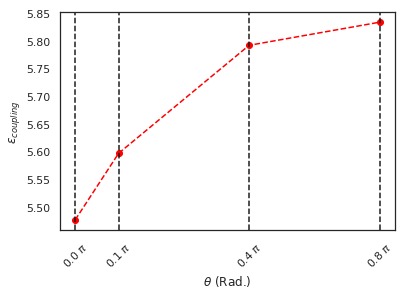

In [30]:
idx = [0, 1, 2, 7]
fig= plt.plot(figsize=(10, 5))
plt.plot(theta_arr[idx], np.array(eps_coupling_list)[idx], 
         color = 'red', marker='o', linestyle='--')
plt.xlabel(r'$\theta$ (Rad.)')
plt.ylabel(r'$\epsilon_{coupling}$')
plt.xticks(theta_arr[idx], ['{:.1f} $\pi$'.format(i) for i in np.linspace(0, 1, 10)[idx]], rotation=45);

for i in range(len(idx)):
    plt.axvline(x=theta_arr[idx[i]], color='k', linestyle='--')

In [24]:
theta_arr[[0, 1, 4, 7]]

array([0.        , 0.34906585, 1.3962634 , 2.44346095])